In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torch import nn
from torchvision.ops import nms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pathlib
import json
import cv2
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Loading data and Visualization

In [2]:
base_dir = pathlib.Path('data/coco/')
train_images = base_dir/'train2017'
valid_images = base_dir/'val2017'
train_labels_json = base_dir/'annotations/instances_train2017.json'
valid_labels_json = base_dir/'annotations/instances_valid2017.json'

In [3]:
file = open(train_labels_json, 'r')
data = json.load(file)
print(data.keys())
file.close()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])


In [4]:
idx_to_cat = {cat['id']:cat['name'] for cat in data['categories']}
cat_to_idx = {cat['name']:cat['id'] for cat in data['categories']}
print(idx_to_cat)

{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'micro

In [5]:
images = list(train_images.glob('*.jpg'))
print(f'No of Training Images: {len(images)}')

No of Training Images: 118287


In [6]:
images_data = {}
for images in data['images']:
    images_data[images['id']] = {'img_name': images['file_name'], 
                                 'height': images['height'],
                                 'width': images['width']}

In [7]:
complete_data = []
data_columns = {'image_id', 'file_name', 'width', 'height', 'x_1', 'y_1', 'x_2', 'y_2', 'category_idx', 'category_name'}
for annotations in tqdm(data['annotations']):
    current_data = dict()
    image_id = annotations['image_id']
    x1, y1, w, h = annotations['bbox']
    x2, y2 = x1 + w, y1 + h
    category_idx = annotations['category_id']
    category_name = idx_to_cat[category_idx]
    file_name = images_data[image_id]['img_name']
    width = images_data[image_id]['width']
    height = images_data[image_id]['height']

    current_data['image_id'] = image_id
    current_data['file_name'] = file_name
    current_data['width'] = width
    current_data['height'] = height
    current_data['x_1'] = int(x1)
    current_data['y_1'] = int(y1)
    current_data['x_2'] = int(x2)
    current_data['y_2'] = int(y2)
    current_data['category_idx'] = category_idx
    current_data['category_name'] = category_name

    complete_data.append(current_data)

100%|██████████| 860001/860001 [00:02<00:00, 381001.00it/s]


In [21]:
final_df = pd.DataFrame(complete_data).sort_values(by = 'image_id').reset_index(drop = True)
final_df.head()

,image_id,file_name,width,height,x_1,y_1,x_2,y_2,category_idx,category_name
0,9,000000000009.jpg,640,480,376,40,451,86,55,orange
1,9,000000000009.jpg,640,480,465,38,523,85,55,orange
2,9,000000000009.jpg,640,480,311,4,631,232,51,bowl
3,9,000000000009.jpg,640,480,249,229,565,474,56,broccoli
4,9,000000000009.jpg,640,480,364,2,458,73,55,orange


__NOTE:__ x_1 is along x axis (column value) and y_1 is along x axis (row value) similarly for x_2, y_2

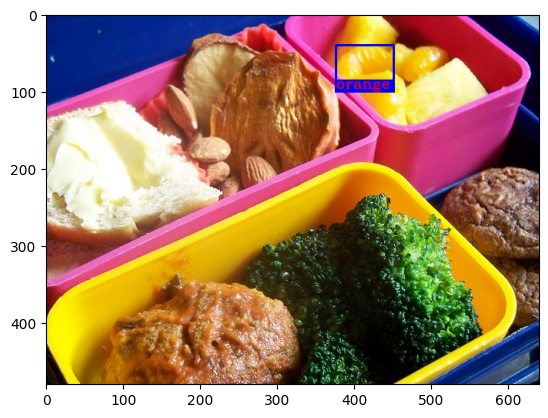

In [39]:
idx = 0
df_sub = final_df.iloc[idx]
img = cv2.imread(str(train_images/df_sub['file_name']))
img = cv2.rectangle(img, (df_sub['x_1'], df_sub['y_1']), (df_sub['x_2'], df_sub['y_2']), (255, 0, 0), 2)
img = cv2.rectangle(img, (df_sub['x_1'] - 1, df_sub['y_2']), (df_sub['x_2'] + 1, df_sub['y_2'] + 15), (255, 0, 0), -1)
img = cv2.putText(img, df_sub['category_name'], (df_sub['x_1'], df_sub['y_2'] + 10), 
                  cv2.FONT_HERSHEY_COMPLEX, 0.6, (0, 0, 255), 1, cv2.LINE_AA)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

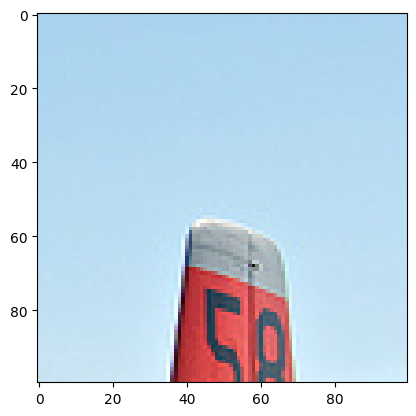

In [16]:
plt.imshow(img[100:200, 400: 500])